## notebook set up

In [38]:
# adjust plot size rendered inline
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)

In [2]:
setwd("..")

In [4]:
library(tidyverse, warn.conflicts = F)
library(DESeq2, warn.conflicts = F)

## read in counts

In [5]:
counts <- read_tsv("outputs/counts/raw_counts.tsv", show_col_types = F)
counts_summary <- counts %>% filter(grepl("^__", gene)) # keep the summary rows produced by htseq
counts <- counts %>% filter(!grepl("^__", gene)) # filter out summary rows produced by htseq

## read in metadata

In [24]:
metadata <- read_tsv("inputs/metadata.tsv", show_col_types = F) %>%
  select(library_name, experiment_title, study_title, sex, host_meal, tissue, blood_meal_hour, blood_meal_hour_range, total_spots) %>%
  group_by(library_name) %>%
  mutate(total_spots = sum(total_spots)) %>%
  mutate(blood_meal_hour_range = factor(blood_meal_hour_range, levels = c("0", "12_48", "72_144", "168_264", "none"))) %>%
  distinct()

In [25]:
# rearrange metadata so that it matches the order of the counts dataframe
metadata <- metadata[order(match(metadata$library_name, colnames(counts))), ]

In [26]:
metadata

library_name,experiment_title,study_title,sex,host_meal,tissue,blood_meal_hour,blood_meal_hour_range,total_spots
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
Solexa-205940,Illumina RNA sequencing of transcriptome paired-end library 'Solexa-205940' containing sample 'AAE2-2',Arthropod Cell Line RNA Seq,unknown,cellline,cell_line,NA,none,18664612
Solexa-205939,Illumina RNA sequencing of transcriptome paired-end library 'Solexa-205939' containing sample 'AAE2-1',Arthropod Cell Line RNA Seq,unknown,cellline,cell_line,NA,none,23827030
Solexa-205930,Illumina RNA sequencing of transcriptome paired-end library 'Solexa-205930' containing sample 'AAE1-2',Arthropod Cell Line RNA Seq,unknown,cellline,cell_line,NA,none,22230203
Solexa-205932,Illumina RNA sequencing of transcriptome paired-end library 'Solexa-205932' containing sample 'AAE1-4',Arthropod Cell Line RNA Seq,unknown,cellline,cell_line,NA,none,28368376
Solexa-205941,Illumina RNA sequencing of transcriptome paired-end library 'Solexa-205941' containing sample 'AAE2-3',Arthropod Cell Line RNA Seq,unknown,cellline,cell_line,NA,none,28090616
Solexa-206001,Illumina RNA sequencing of transcriptome paired-end library 'Solexa-206001' containing sample 'AAE1-1',Arthropod Cell Line RNA Seq,unknown,cellline,cell_line,NA,none,29514217
Solexa-205931,Illumina RNA sequencing of transcriptome paired-end library 'Solexa-205931' containing sample 'AAE1-3',Arthropod Cell Line RNA Seq,unknown,cellline,cell_line,NA,none,25317359
Solexa-205942,Illumina RNA sequencing of transcriptome paired-end library 'Solexa-205942' containing sample 'AAE2-4',Arthropod Cell Line RNA Seq,unknown,cellline,cell_line,NA,none,27228254
AmbamSG7-11d,Salivary gland transcriptome of adult female Amblyomma americanum ticks fed for 7-11 days,Amblyomma americanum adult female salivary gland transcriptome,female,sheep,salivary_gland,168;192;216;264,168_264,44443612


## deseq2

In [27]:
dds <- DESeqDataSetFromMatrix(counts %>% column_to_rownames("gene"),
                              colData = metadata,
                              design = ~ blood_meal_hour_range + sex + tissue)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


ERROR: Error in checkFullRank(modelMatrix): the model matrix is not full rank, so the model cannot be fit as specified.
  One or more variables or interaction terms in the design formula are linear
  combinations of the others and must be removed.

  Please read the vignette section 'Model matrix not full rank':

  vignette('DESeq2')


## deseq2 with full rank model

In [28]:
# filter out some stuff so model will be full rank
metadata_fullrank <- metadata %>%
  filter(tissue != "cell_line")

In [29]:
counts_fullrank <- counts %>%
  dplyr::select(c(gene, metadata_fullrank$library_name)) %>%
  as.data.frame() %>%
  column_to_rownames("gene")

# rearrange metadata so that it matches the order of the counts dataframe
metadata_fullrank <- metadata_fullrank[order(match(metadata_fullrank$library_name, colnames(counts_fullrank))), ]

In [30]:
dds <- DESeqDataSetFromMatrix(counts_fullrank,
                              colData = metadata_fullrank,
                              design = ~ blood_meal_hour_range + sex + tissue)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
factor levels were dropped which had no samples



In [31]:
ds <- DESeq(dds, test="Wald")

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1732 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [32]:
resultsNames(ds)

[1] "Intercept"                          "blood_meal_hour_range_12_48_vs_0"  
[3] "blood_meal_hour_range_72_144_vs_0"  "blood_meal_hour_range_168_264_vs_0"
[5] "sex_male_vs_female"                 "tissue_salivary_gland_vs_midgut"   
[7] "tissue_whole_vs_midgut"

## Assess initially with PCA

In [33]:
vsd <- vst(dds, blind=FALSE)

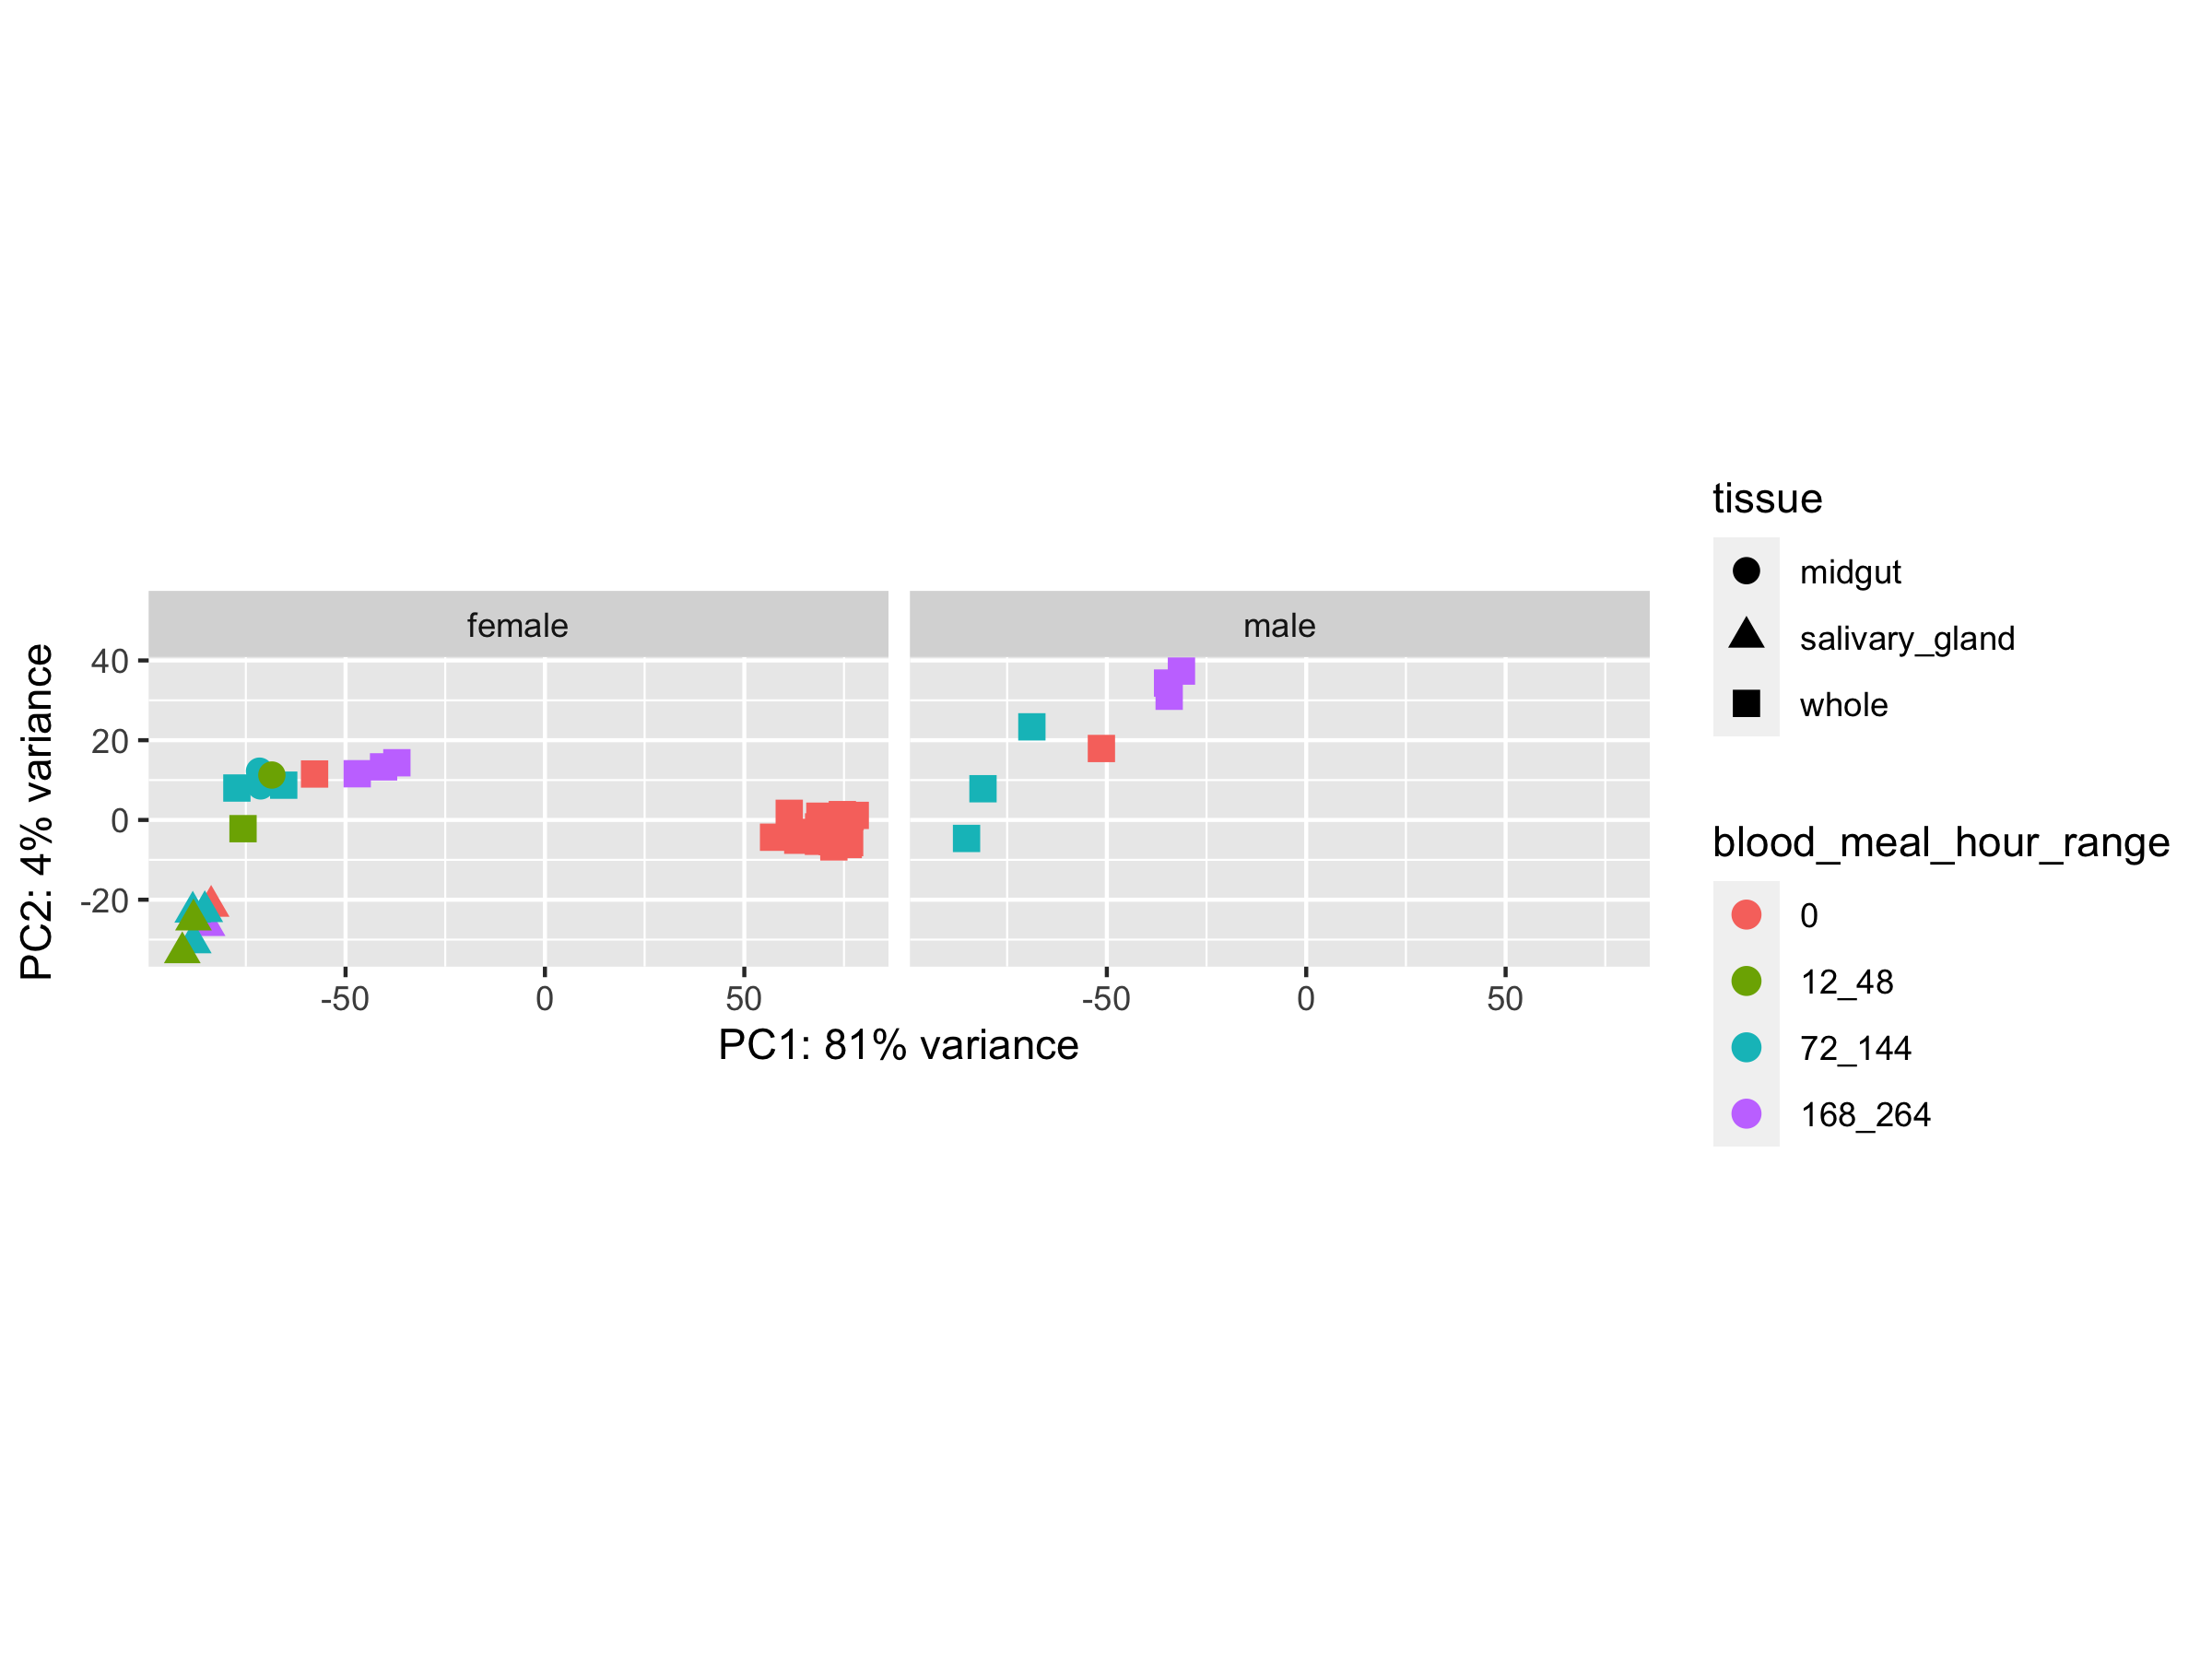

In [39]:
pcad <- plotPCA(vsd, intgroup = c("blood_meal_hour_range", "tissue", "sex"), returnData=TRUE)
percentVar <- round(100 * attr(pcad, "percentVar"))
ggplot(pcad, aes(PC1, PC2, color=blood_meal_hour_range, shape=tissue)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() +
  facet_wrap(~sex)

In [42]:
tmp <- pcad %>% left_join(metadata_fullrank, by = c("name" = "library_name", "tissue", "sex", "blood_meal_hour_range"))

In [44]:
tmp

PC1,PC2,group,blood_meal_hour_range,tissue,sex,name,experiment_title,study_title,host_meal,blood_meal_hour,total_spots
<dbl>,<dbl>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
-84.72792,-26.4412007,168_264:salivary_gland:female,168_264,salivary_gland,female,AmbamSG7-11d,Salivary gland transcriptome of adult female Amblyomma americanum ticks fed for 7-11 days,Amblyomma americanum adult female salivary gland transcriptome,sheep,168;192;216;264,44443612
-88.18957,-30.7737986,72_144:salivary_gland:female,72_144,salivary_gland,female,AmbamSG72-144h,Salivary gland transcriptome of adult female Amblyomma americanum ticks fed for 72-144 hours,Amblyomma americanum adult female salivary gland transcriptome,sheep,72;120;144,49791091
-90.94047,-33.2631095,12_48:salivary_gland:female,12_48,salivary_gland,female,AmbameSG12-18h,Salivary gland transcriptome of adult female Amblyomma americanum ticks fed for 12-48 hours,Amblyomma americanum adult female salivary gland transcriptome,sheep,12;18;24;36;48,25095072
-83.71244,-21.6128132,0:salivary_gland:female,0,salivary_gland,female,AmbamSGunfed,Salivary glands transcriptome of unfed adult female Amblyomma americanum ticks,Amblyomma americanum adult female salivary gland transcriptome,unfed,0,53124914
-85.18471,-4.6362953,72_144:whole:male,72_144,whole,male,PL17,Fed Males,Amblyomma americanum strain:Stillwater Oklahoma Transcriptome or Gene expression,rabbit,72,413856
-81.05883,7.8286342,72_144:whole:male,72_144,whole,male,PL3,Fed males,Amblyomma americanum strain:Stillwater Oklahoma Transcriptome or Gene expression,rabbit,72,850276
-77.25331,8.0065197,72_144:whole:female,72_144,whole,female,PL2,4 day fed females,Amblyomma americanum strain:Stillwater Oklahoma Transcriptome or Gene expression,rabbit,96,1031591
-75.71089,-2.1871908,12_48:whole:female,12_48,whole,female,PL1,24h fed female,Amblyomma americanum strain:Stillwater Oklahoma Transcriptome or Gene expression,rabbit,24,740878
-68.79994,23.3481614,72_144:whole:male,72_144,whole,male,AAFM,Fed Male Whole Tick,Amblyomma americanum strain:Stillwater Oklahoma Transcriptome or Gene expression,rabbit,72,50887


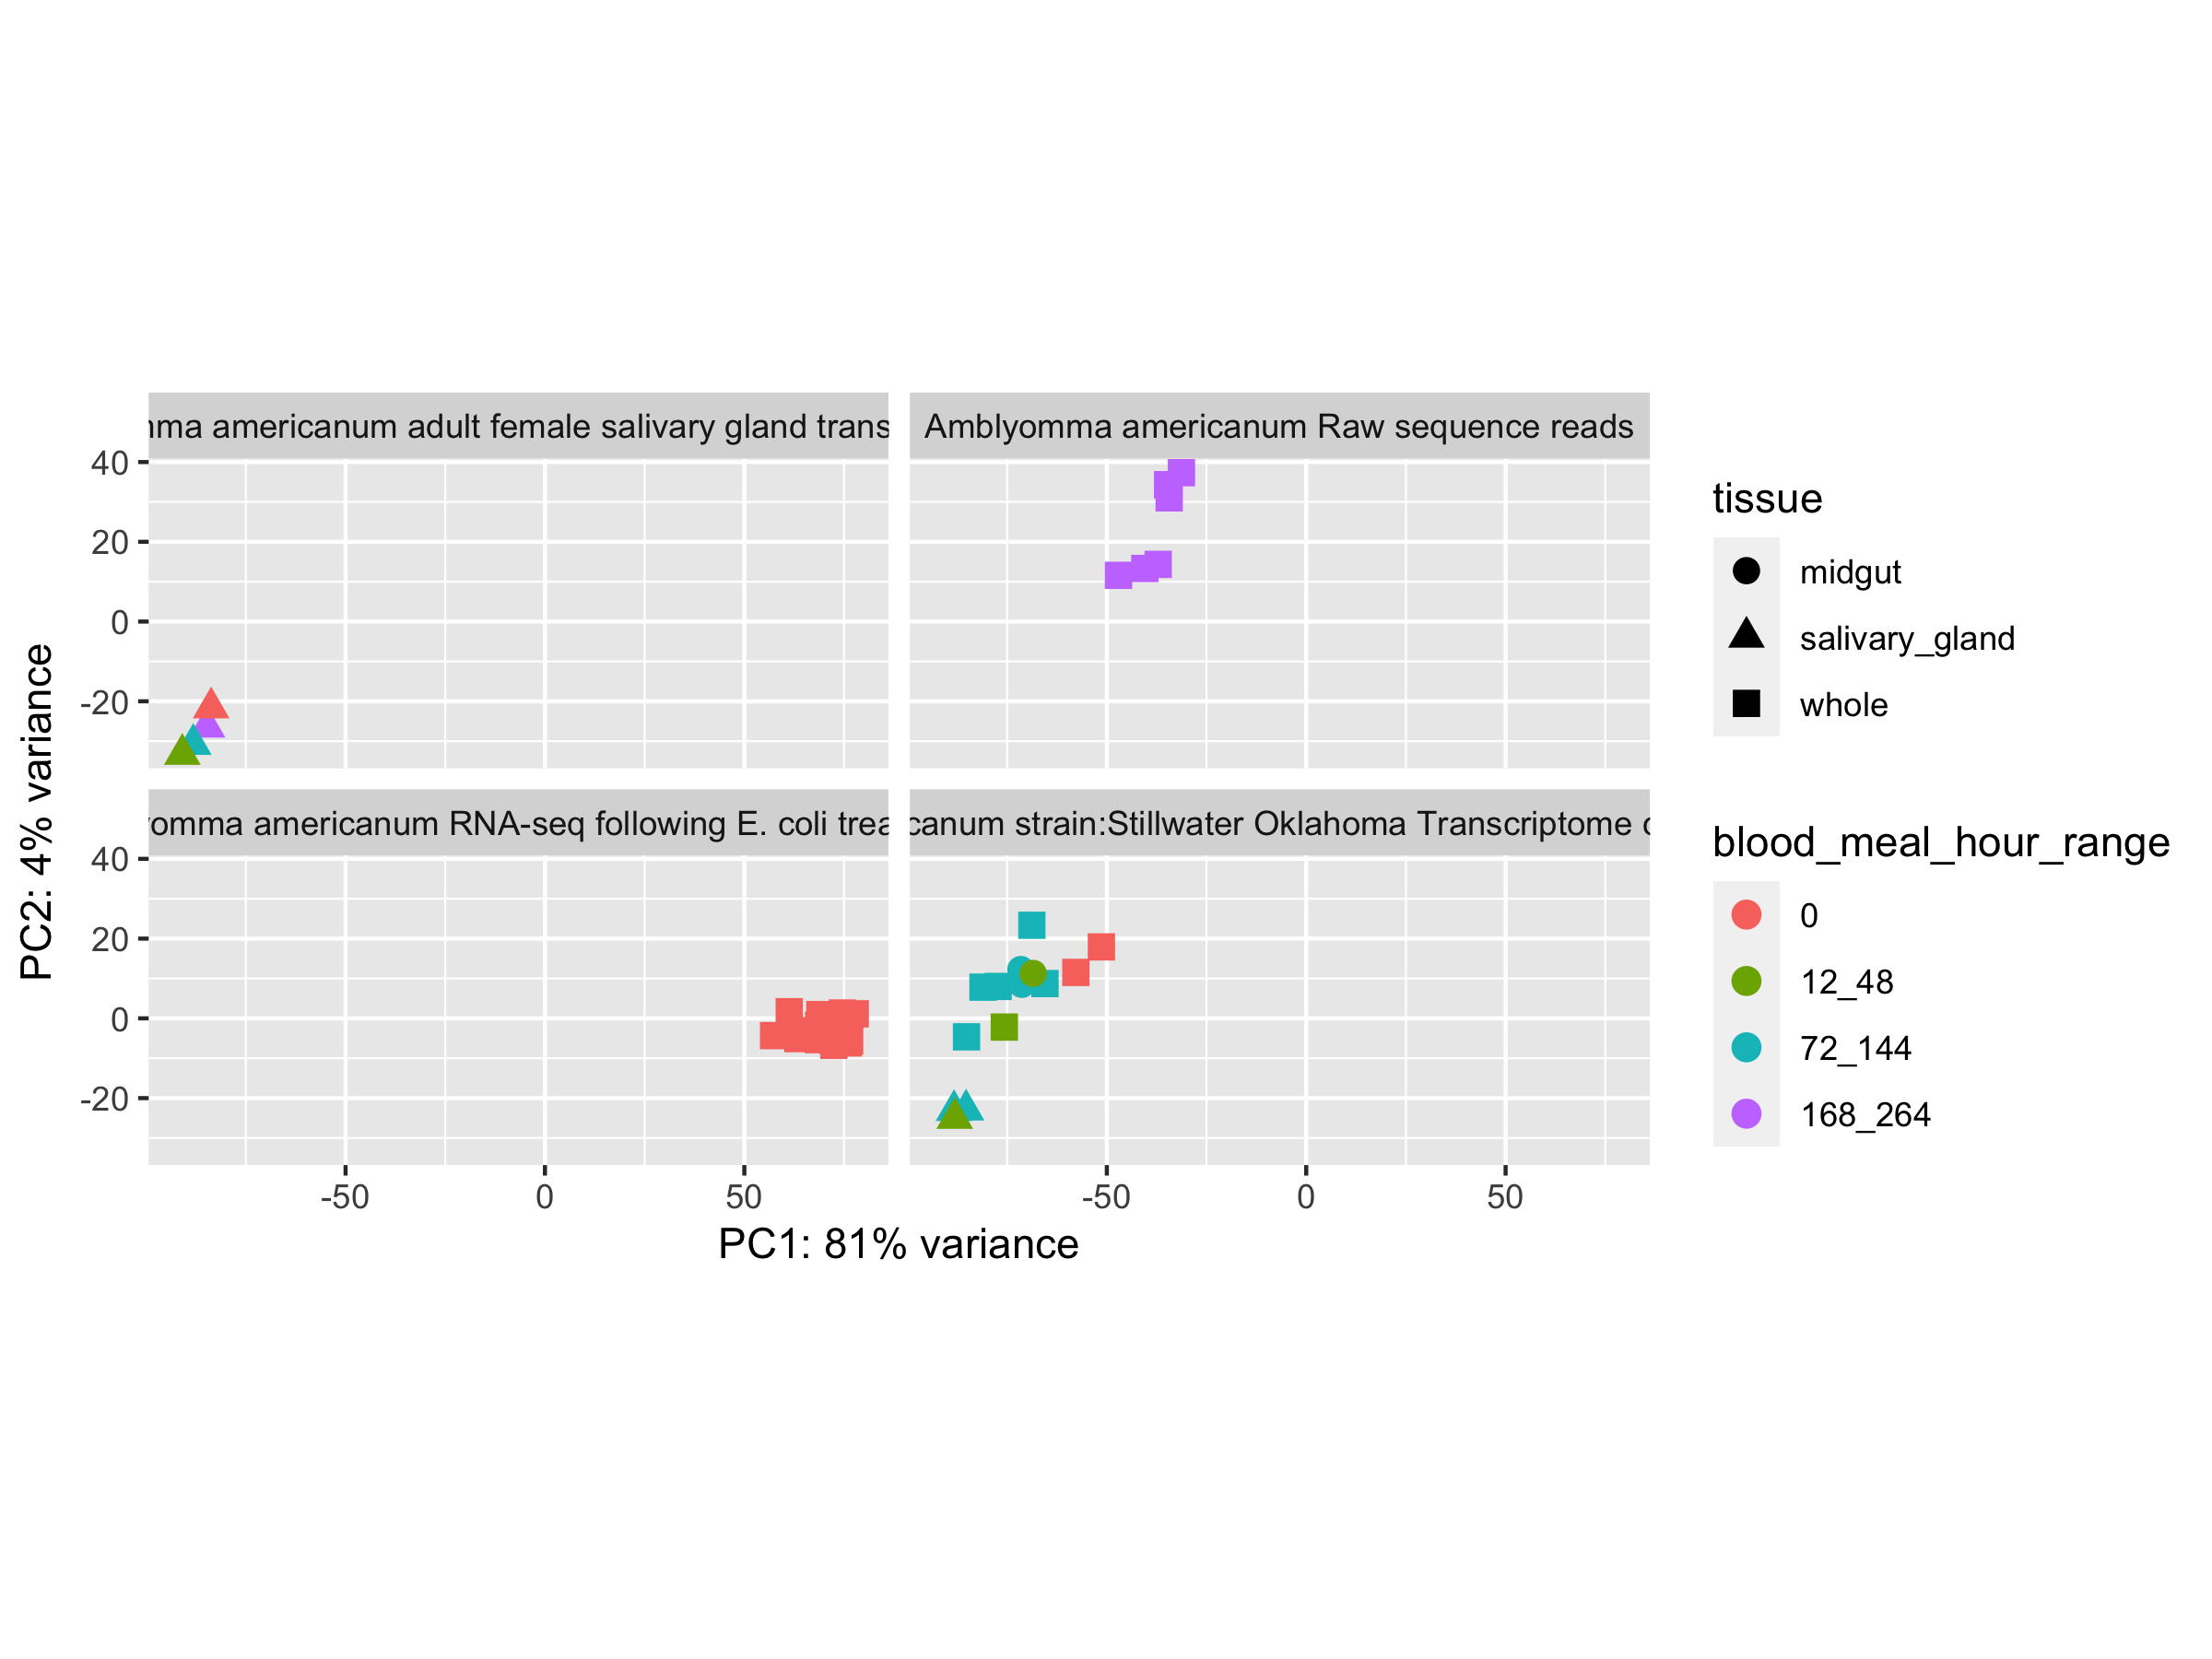

In [45]:
ggplot(tmp, aes(PC1, PC2, color=blood_meal_hour_range, shape=tissue)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() +
  facet_wrap(~study_title)

## remove samples I dont like and try again

In [46]:
# filter out some stuff so model will be full rank
metadata_fullrank <- metadata %>%
  filter(tissue != "cell_line") %>%
  filter(!study_title %in% "Amblyomma americanum RNA-seq following E. coli treatment") %>% # rm e. coli study, too batched
  filter(!library_name %in% c("Um", "Uf", "Im", "If")) # filter e chaf exposed samples

counts_fullrank <- counts %>%
  dplyr::select(c(gene, metadata_fullrank$library_name)) %>%
  as.data.frame() %>%
  column_to_rownames("gene")

# rearrange metadata so that it matches the order of the counts dataframe
metadata_fullrank <- metadata_fullrank[order(match(metadata_fullrank$library_name, colnames(counts_fullrank))), ]

In [47]:
dds <- DESeqDataSetFromMatrix(counts_fullrank,
                              colData = metadata_fullrank,
                              design = ~ blood_meal_hour_range + sex + tissue)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
factor levels were dropped which had no samples



In [48]:
ds <- DESeq(dds, test="Wald")

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [ ]:
resultsNames(ds)

## assess with PCA

In [49]:
vsd <- vst(dds, blind=FALSE)

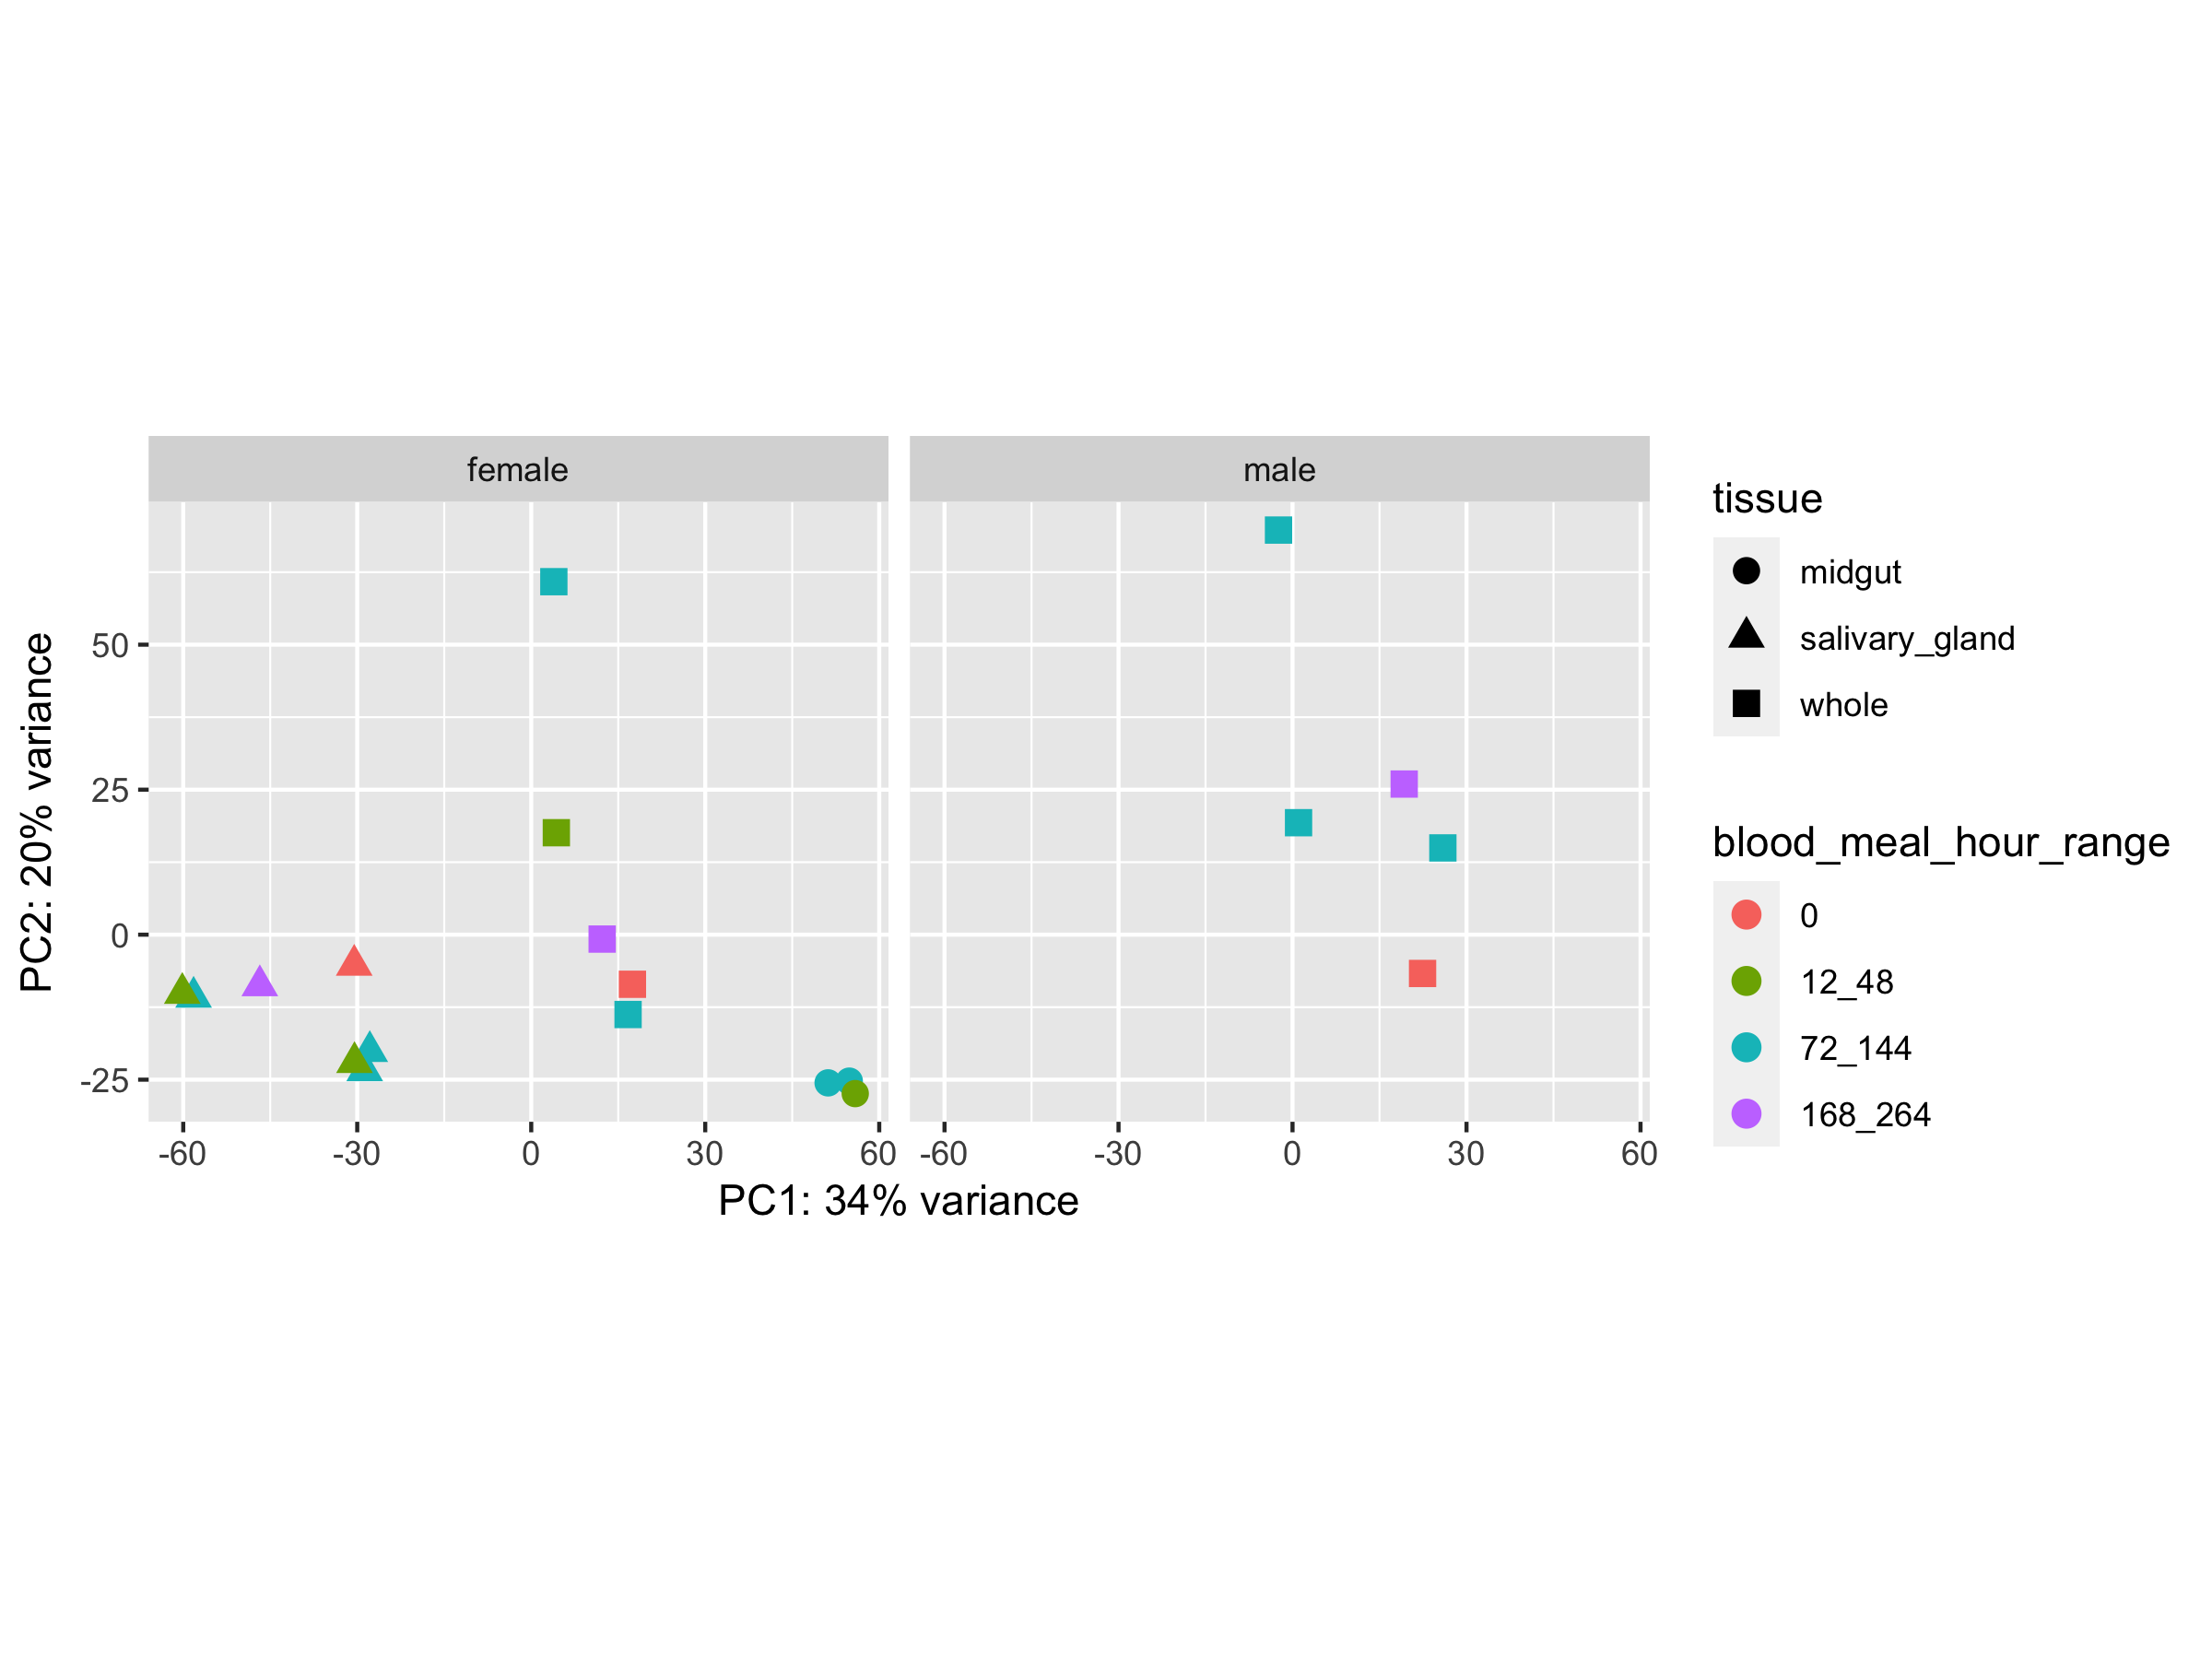

In [50]:
pcad <- plotPCA(vsd, intgroup = c("blood_meal_hour_range", "tissue", "sex"), returnData=TRUE)
percentVar <- round(100 * attr(pcad, "percentVar"))
ggplot(pcad, aes(PC1, PC2, color=blood_meal_hour_range, shape=tissue)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() +
  facet_wrap(~sex)

In [51]:
tmp <- pcad %>% left_join(metadata_fullrank, by = c("name" = "library_name", "tissue", "sex", "blood_meal_hour_range"))

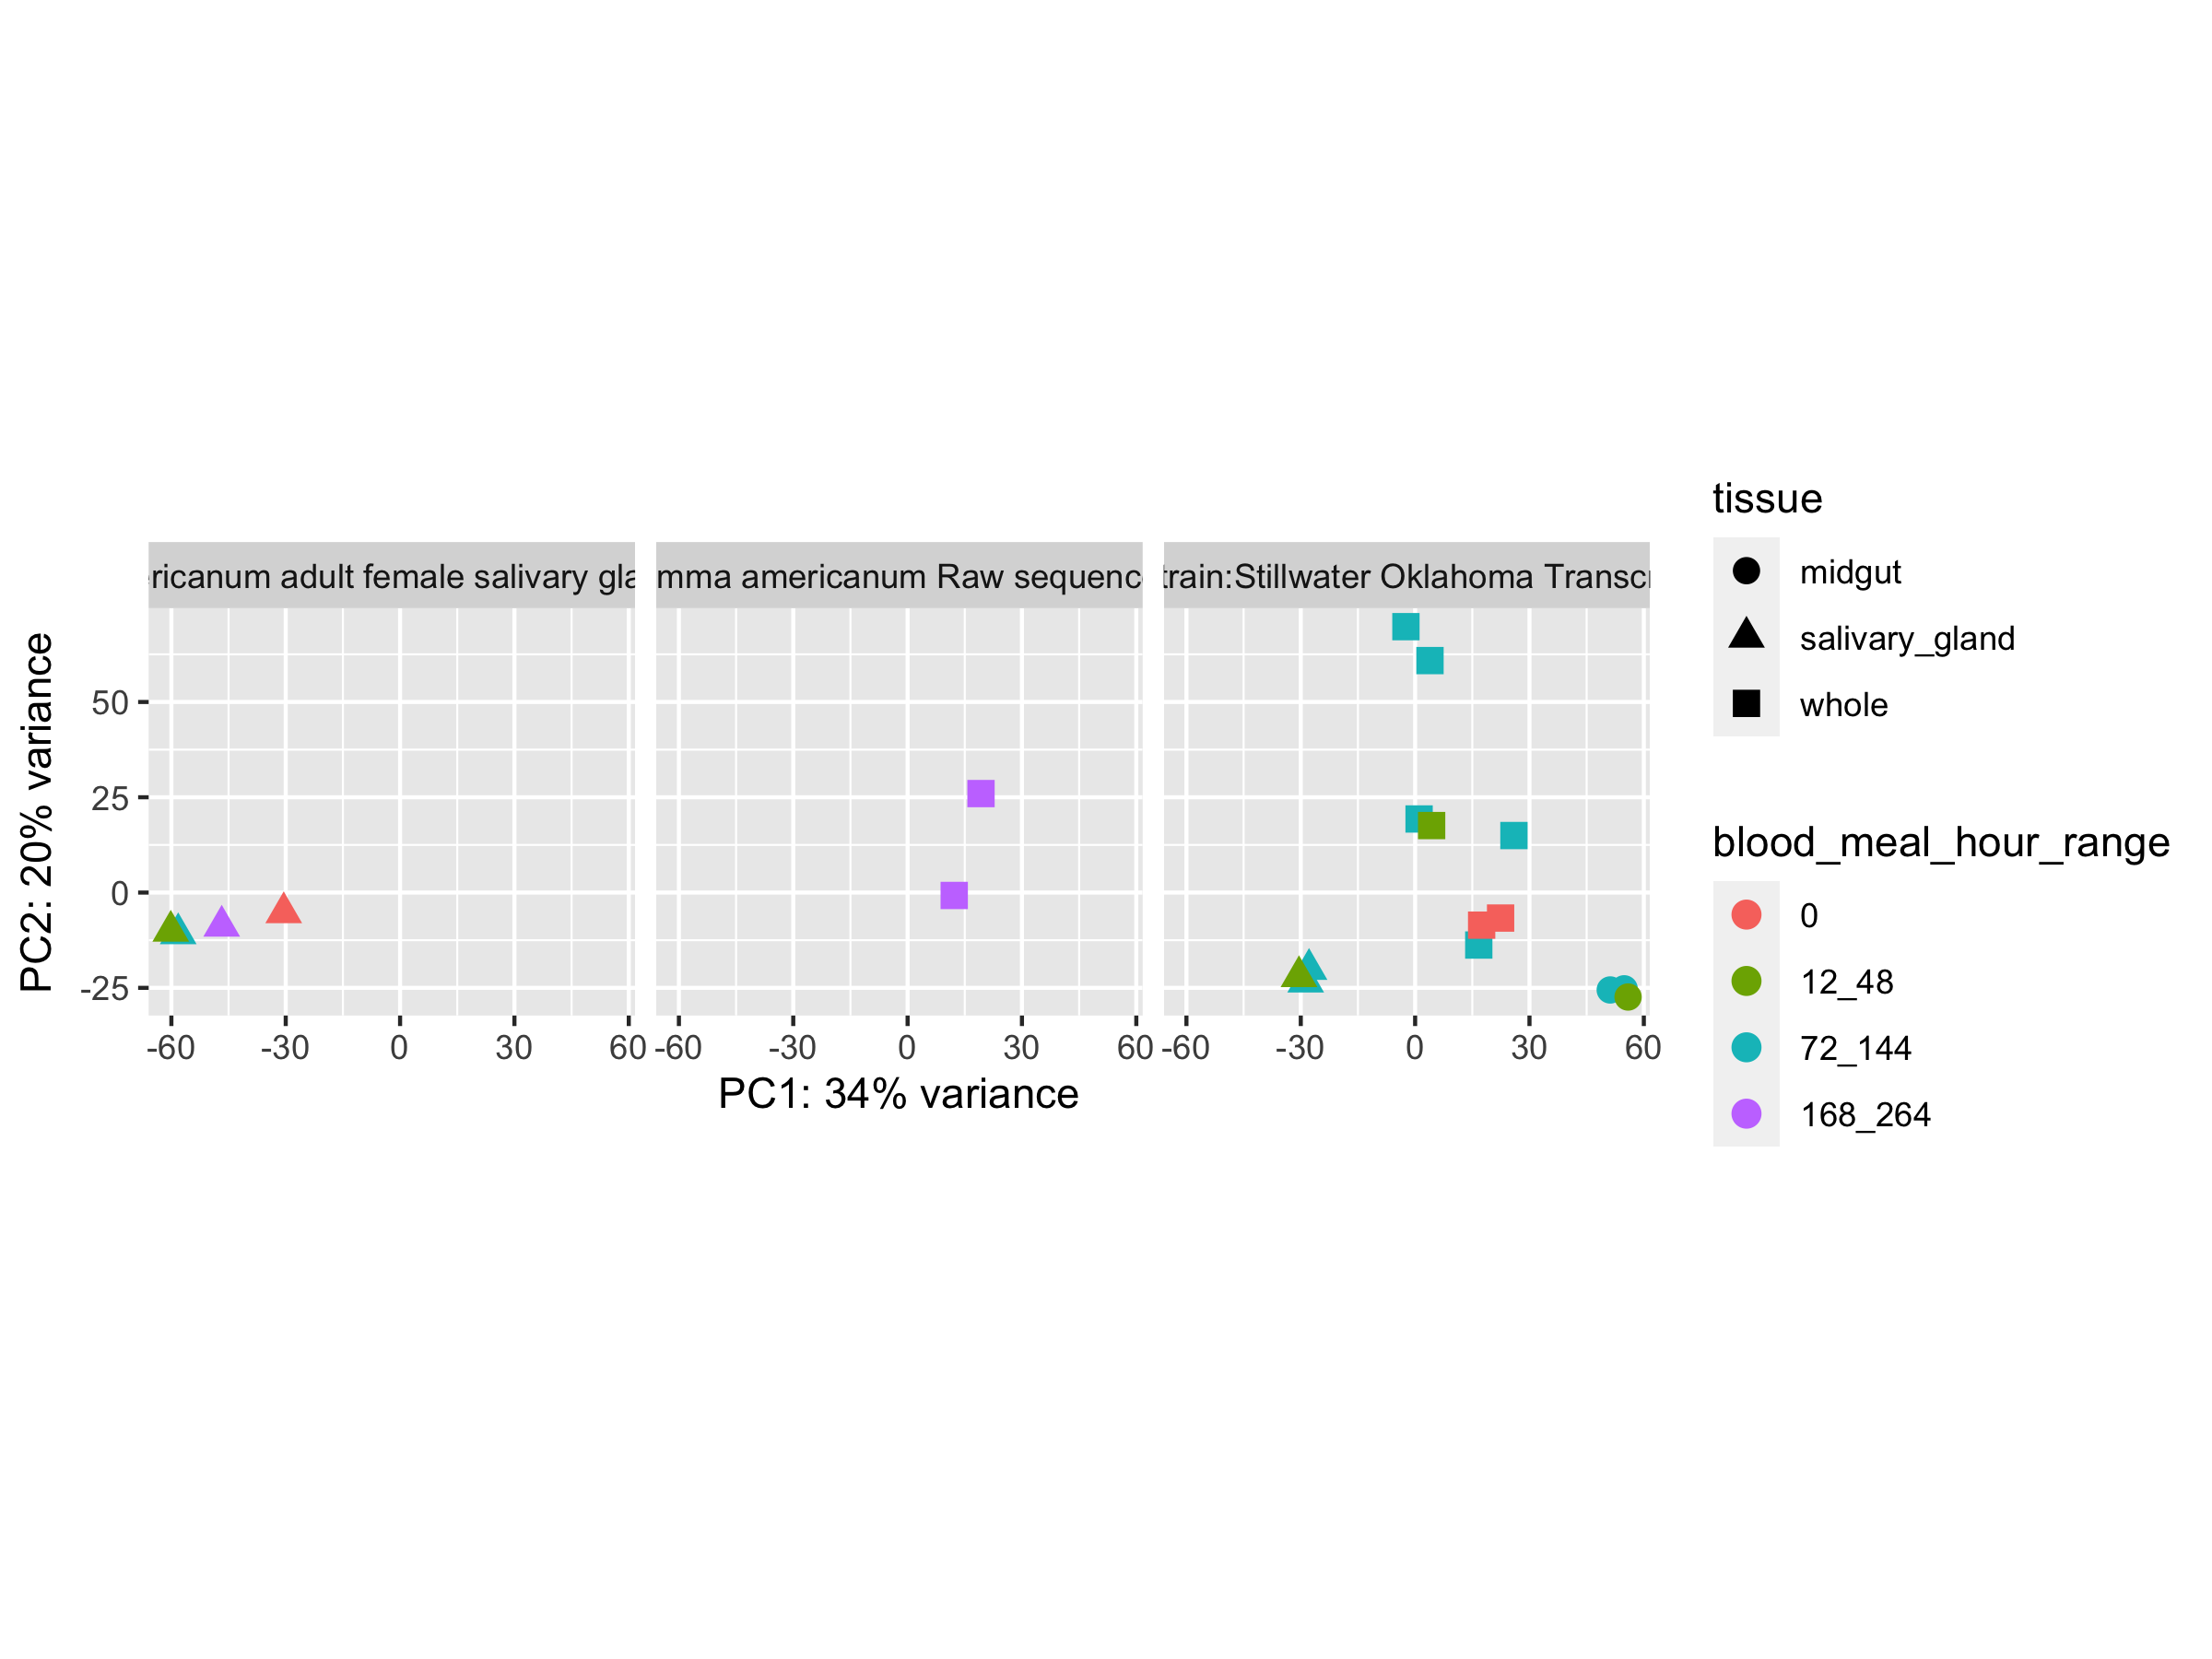

In [52]:
ggplot(tmp, aes(PC1, PC2, color=blood_meal_hour_range, shape=tissue)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() +
  facet_wrap(~study_title)

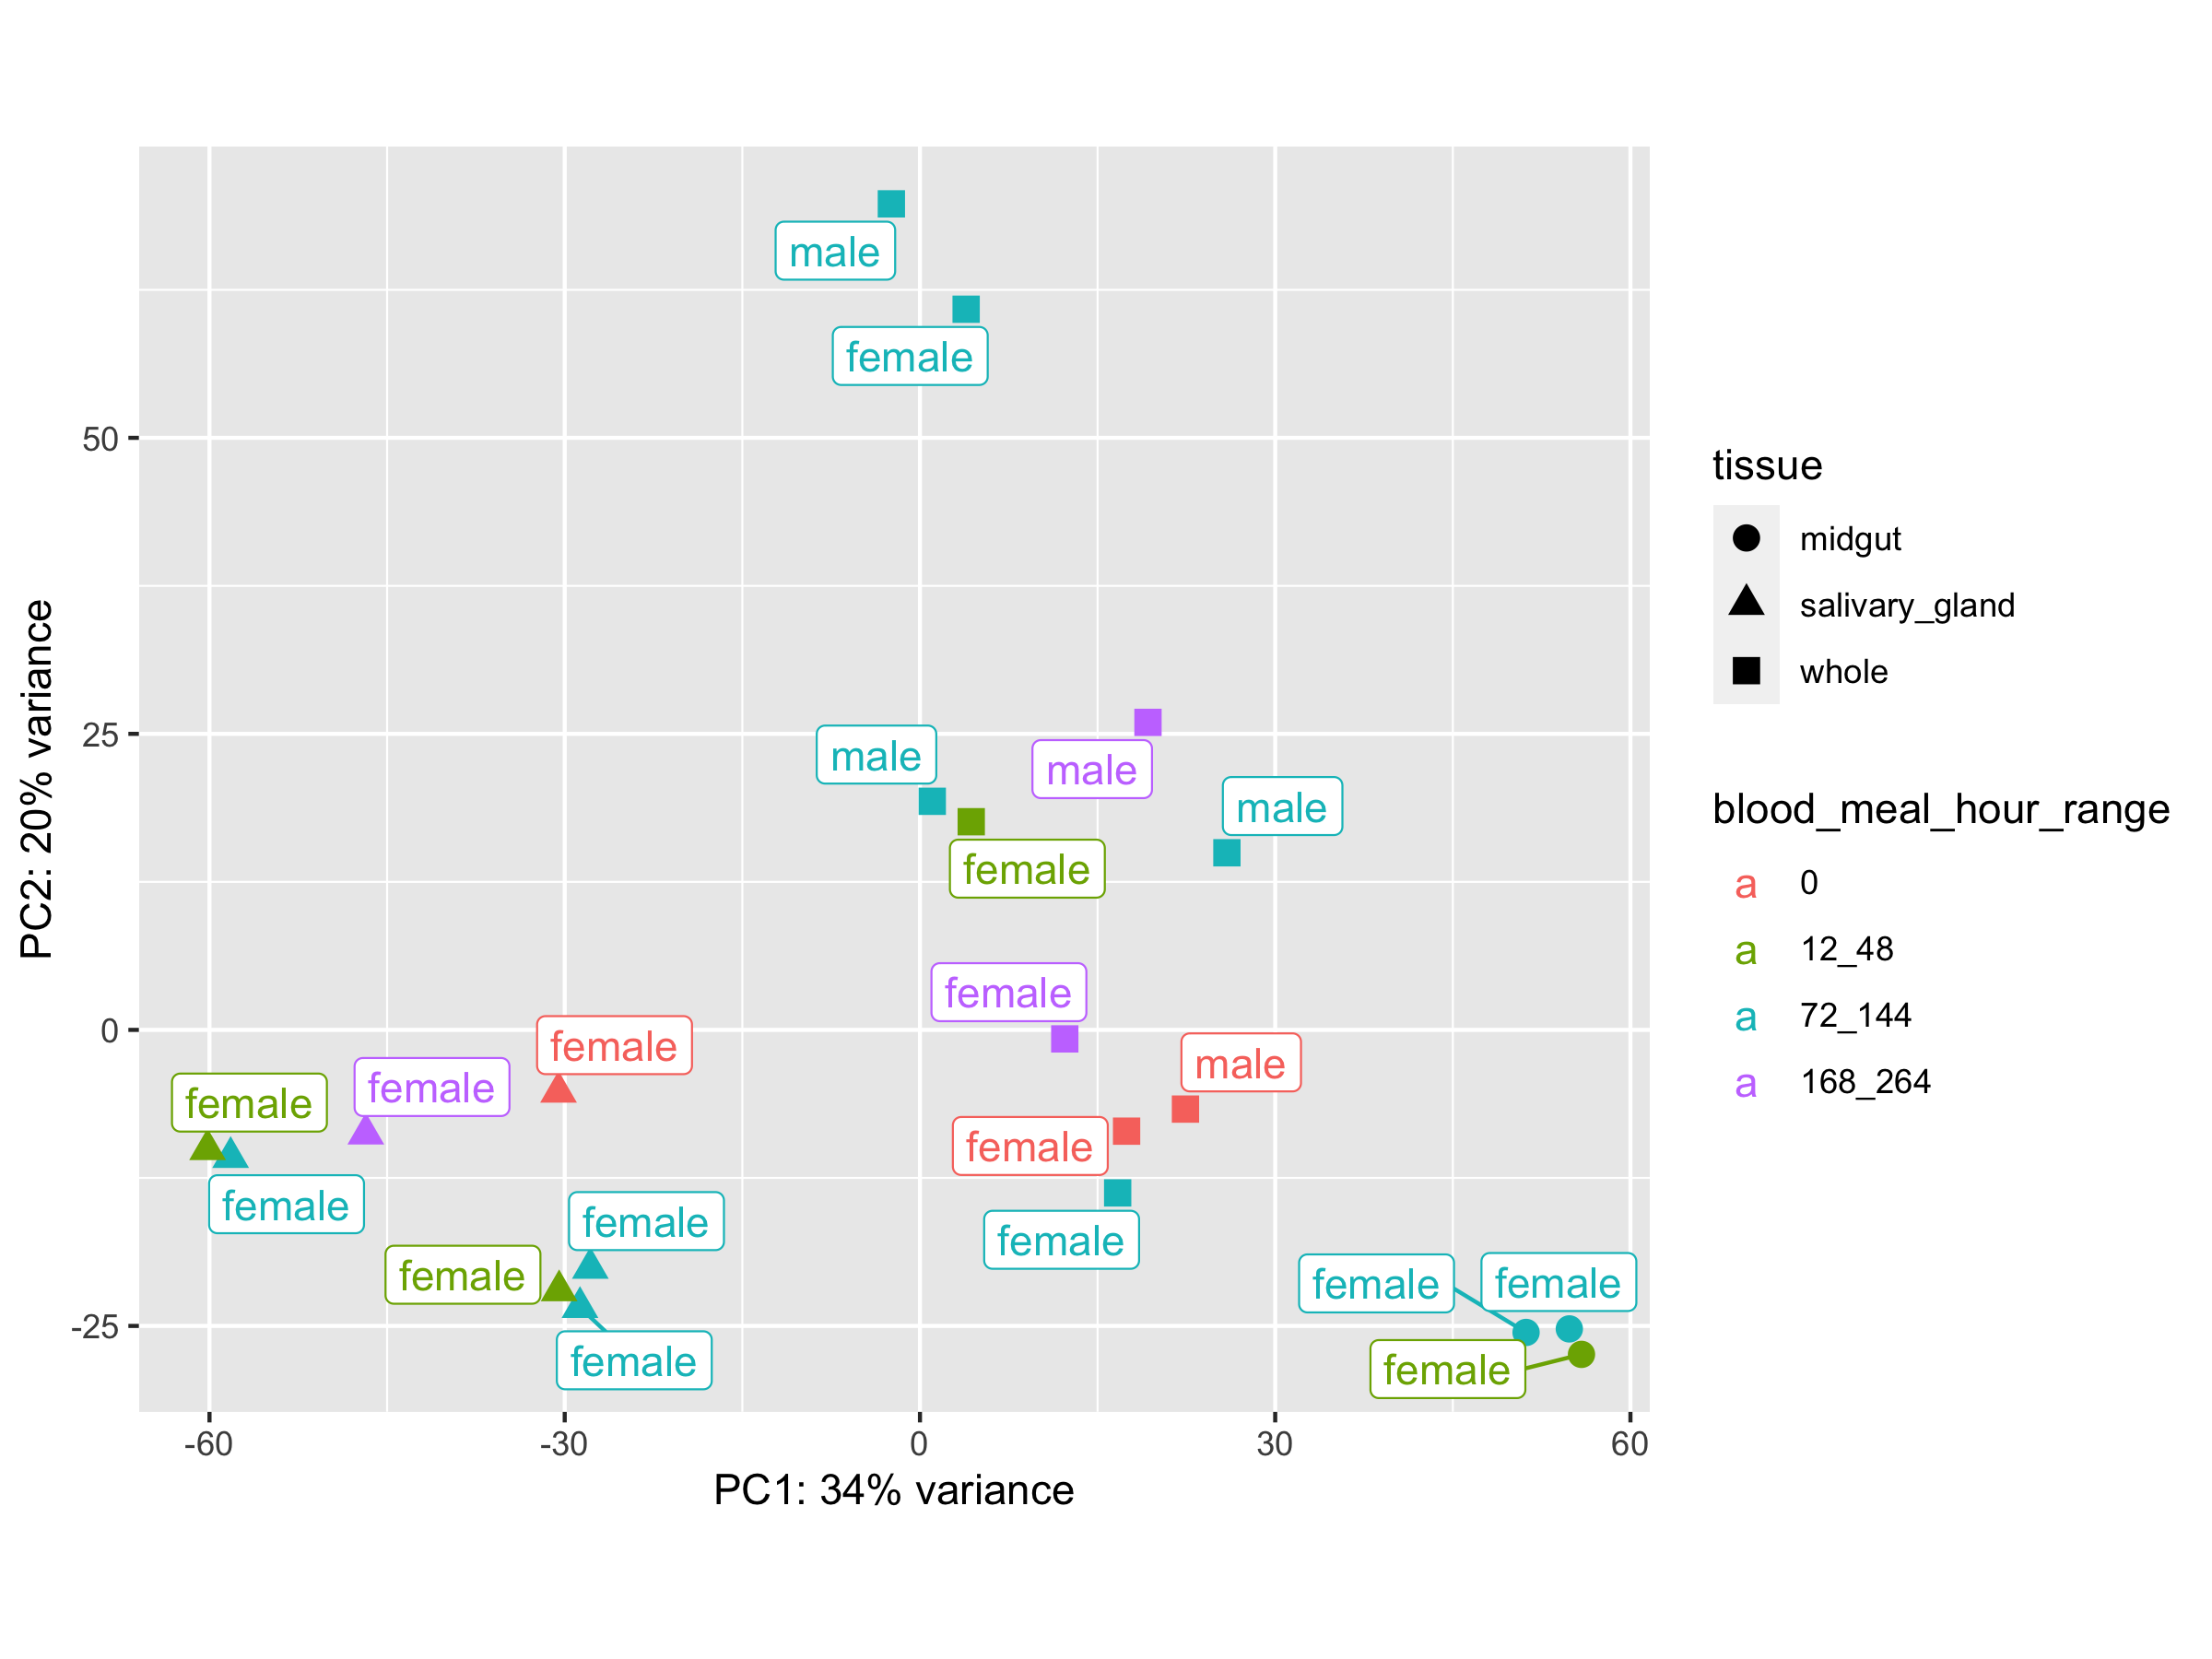

In [59]:
ggplot(tmp, aes(PC1, PC2, color=blood_meal_hour_range, shape=tissue, label = sex)) +
  geom_point(size=3) +
  xlab(paste0("PC1: ",percentVar[1],"% variance")) +
  ylab(paste0("PC2: ",percentVar[2],"% variance")) + 
  coord_fixed() +
  ggrepel::geom_label_repel()